# WELCOME TO THE ML @ SAPIENZA HACKATHON 2023/24!

This is a short welcome kit to familiarize with the topics of the Hackathon: *digital music* 🎹

Please read this notebook from start to end, because you'll need some of these functions and tools!

# Google Colab

Please note that this version of the notebook is supposed to be ran on Google Colab.

If you want to run the tutorial on your local machine, please use the other notebook.

First we need to mount your Google Drive as a disk, so as the machine running your code can access all of its files.

If Colab opens some popups up and asks authorization to access your drive, accept it, otherwise, it will not be able to read your files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After having mounted the drive, we need to get the necessary tools and inputs for the tutorial.

We are going to do it by cloning the "Audio Processing Starter Kit" repository from GitHub

In [2]:
!git clone https://github.com/ML-MSAI-2024-hackathon/audio-processing-starter-kit.git audio_processing_starter_kit

fatal: destination path 'audio_processing_starter_kit' already exists and is not an empty directory.


Finally, we are going to install all required dependencies

In [3]:
!pip install -r ./audio_processing_starter_kit/requirements.txt

## Fundamentals

Let's first import the required libraries:

In [4]:
from pydub import AudioSegment
import librosa

**NOTE:** If you *don't* use Colab and want to use your laptop's GPU, make sure to install `torch` with CUDA enabled:

```pip3 install torch torchaudio --index-url https://download.pytorch.org/whl/cu118 ```

Visit [https://pytorch.org/](the official website) to get the exact string for your OS.

And here are some utility functions that we will need in this demo. You don't need to understand how they work to complete this notebook!

In [5]:
import sys
sys.path.append('./audio_processing_starter_kit')

In [6]:
from utils import *

Let's start playing some sounds! 🎶

We use the `AudioSegment` class to load sounds and play them. Execute the following cell to get a small embedded player:

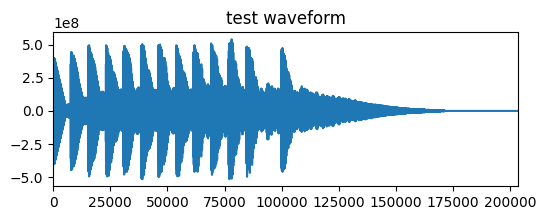

In [7]:
audio = AudioSegment.from_wav("./audio_processing_starter_kit/test.wav")
player(audio, zoom=1, title="test waveform")

# push the play button!

Did you enjoy those smooth notes?

You might be wondering what is that function plot we see below the player. If you already know what it is, a brief refresher doesn't hurt. If it's the first time you delve into this, welcome to the world of **Digital Sound Processing**!! 🕺

A simple way to represent sound is as a **list of samples**. Let's try to zoom into the plot above:

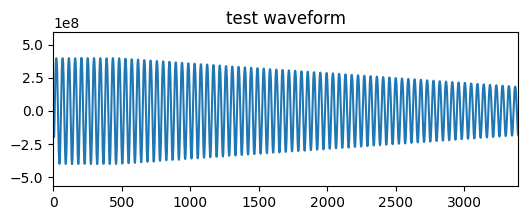

In [8]:
player(audio, zoom=60., title="test waveform")

The zoom only shows a small portion of the entire soundwave. On the *x*-axis we see time; on the *y*-axis, we have the **sample** amplitude. Therefore, in the plot above we are looking at a window of roughly $3,500$ samples.

How many samples in time are we using to represent the entire audio file? Let's see:

In [9]:
print(len(audio.get_array_of_samples()))

203520


Wow, that's a lot of samples for just $8$ seconds of music! If each of these samples was a letter of the alphabet, we would have a book of $150$ pages!

That's because we are representing sound using $24,000$ samples per second; in signal processing we say that the **sample rate** (or **frame rate**) of this example is $24$ kHz.

In [10]:
print(audio.frame_rate)

24000


Sometimes you need to process audio more quickly, or you need to save some memory, hence it can be useful to decrease the sample rate. Let's do this:

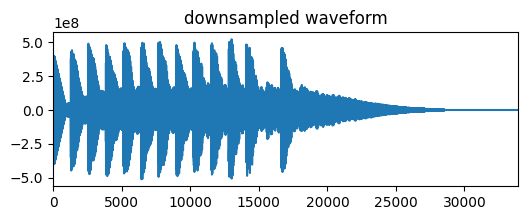

In [11]:
audio_downsampled = audio.set_frame_rate(4000)
player(audio_downsampled, zoom=1., title="downsampled waveform")

The sound quality has decreased, but it sounds acceptable given the 6x times reduction in memory!

Finally, each of the $33,920$ samples of this downsampled soundwave is stored with a certain precision; is it just $1$ byte per sample? $4$ bytes? Are these integer values, or floating point numbers? Are these signed or unsigned numbers?

Let's check:

In [12]:
print(audio.sample_width)

4


The **sample width** is the number of bytes used to represent each sample. As you can imagine, it determines the sound quality. The wider, the merrier!

Let's try to reduce the sample width to just $1$ byte per sample:

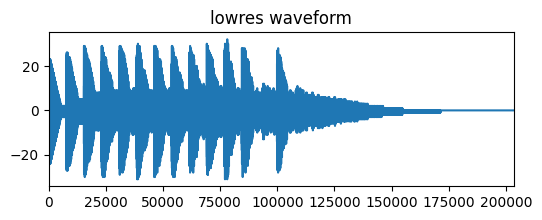

In [13]:
audio_lowres = audio.set_sample_width(1)
player(audio_lowres, zoom=1., title="lowres waveform")

You can still hear what's going on, but there's strong background noise!

To conclude, there is a trade-off between sound quality and efficiency when we deal with digital audio; however, for a ML project, it might be good to reduce quality whenever needed, if it makes things easier to test!

## Spectrograms

Representing sound as a scalar function over time is not the only possibility.

In fact, it is very common in sound processing to use **spectrograms**. Let's compute one right away! First, we choose some parameters for the spectrogram computation:

In [14]:
device = "cpu"  # change to "cpu" if you don't have a GPU

# NOTE: these parameters are optimized for a sample rate of 44.1 kHz
params = SpectrogramParams(
            sample_rate=44100,
            stereo=False,
            step_size_ms=10,
            min_frequency=20,
            max_frequency=20000,
            num_frequencies=512,
        )

converter = SpectrogramConverter(params=params, device=device)

And here's the computed spectrogram:

Text(0.5, 1.0, 'Original')

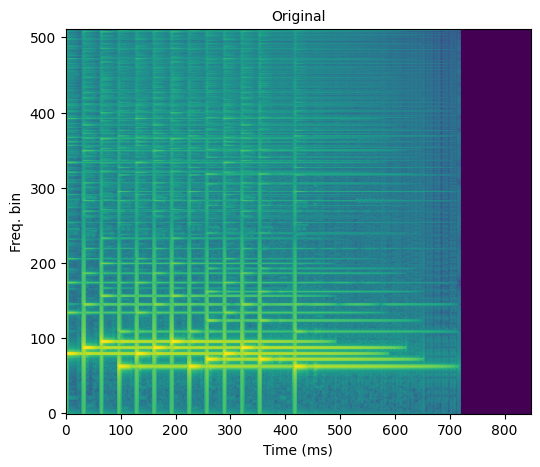

In [15]:
audio = audio.set_frame_rate(params.sample_rate)
spectrogram = converter.spectrogram_from_audio(audio)

plt.figure(figsize=(6,5))
plt.imshow(librosa.power_to_db(spectrogram.squeeze()), origin='lower', aspect='auto', interpolation="nearest")
plt.ylabel('Freq. bin')
plt.xlabel('Time (ms)')
plt.title('Original', fontsize=10)

From the image above, we observe a few things:

- The *x*-axis represents **time**.
- The *y*-axis seems to represent musical notes! Look at the yellow arrow-like traces: they go up and down just like the notes in the short music piece.
- There is an empty region on the right, corresponding to *silence*.

The reason why the $y$-axis seems to represent musical notes, it's because it represents **frequency**, i.e. the oscillation speed of the soundwave. And in fact, according to music theory, **different notes correspond to different frequencies**.

Can we go back from spectrogram to soundwave? Sure:

Converting... done.


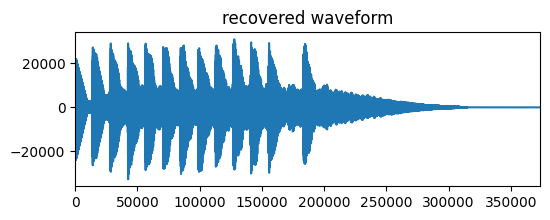

In [16]:
audio_recovered = converter.audio_from_spectrogram(spectrogram, do_apply_filters=False)
player(audio_recovered, zoom=1., title="recovered waveform")

The spectrogram transform is *invertible*. But it may be a better representation for ML pipelines, since essentially it is a 2D image!

Also, it's easier to **manipulate**. For example, you can apply image processing techniques like smoothing, interpolation and deformation, then convert back to the time domain of the soundwave, and listen to what new sounds you created. It's actually pretty fun! 🤪

## Features

In addition to the spectrogram, there are many other **audio features** you can extract! Things like the *spectral centroid*, or the *bandwidth*, or the *zero crossing rate* are informative and can help in ML tasks.

The `librosa` library comes with ready-to-use functions to compute audio features. [Check the docs!](https://librosa.org/doc/0.10.2/feature.html)

## Composing music

Don't worry, you don't have to be a great composer -- you just have to be a good listener!🎧

Let's load a song:

Loading ./audio_processing_starter_kit/demo.mod... done.


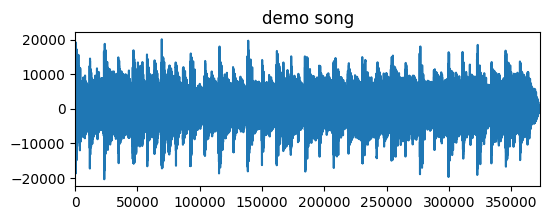

In [17]:
from modsong import MODSong, Sample

song = MODSong()
song.load_from_file("./audio_processing_starter_kit/demo.mod")

player(song, zoom=1., title="demo song")

The song is already composed for you, but you can change a few things!

For example, here's a list of its instruments (here they are called *samples*, but don't confuse these samples with the soundwave samples we explained above!):

In [18]:
for i in range(len(song.samples)):
    print(f"Sample {i}: {song.samples[i].name}")

Sample 0: pingbells
Sample 1: 
Sample 2: dreambells
Sample 3: korgbeau
Sample 4: strings1
Sample 5: 
Sample 6: polysynth
Sample 7: 
Sample 8: 
Sample 9: 
Sample 10: 
Sample 11: 
Sample 12: hihat2
Sample 13: popsnare2
Sample 14: bassdrum3
Sample 15: 
Sample 16: 
Sample 17: 
Sample 18: 
Sample 19: 
Sample 20: 
Sample 21: 
Sample 22: 
Sample 23: 
Sample 24: 
Sample 25: 
Sample 26: 
Sample 27: 
Sample 28: 
Sample 29: 
Sample 30: 


As you can see, the song has $31$ samples in total, but not all of them are used! The used ones have a name. For example, sample n. $6$ is called "polysynth", which is some kind of synthetic sound.

Let's have a look at it!

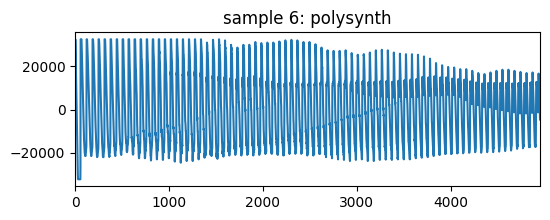

In [19]:
s6 = AudioSegment(data=song.samples[6].waveform, sample_width=2, frame_rate=44100, channels=1)
player(s6, zoom=1., title=f"sample 6: {song.samples[6].name}")

And here's the bassdrum, corresponding to sample $14$:

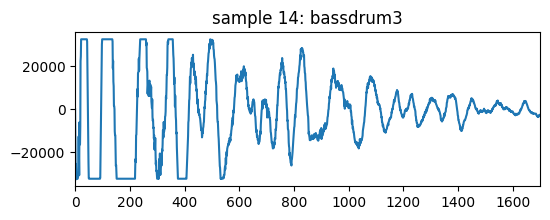

In [20]:
s6 = AudioSegment(data=song.samples[14].waveform, sample_width=2, frame_rate=44100, channels=1)
player(s6, zoom=1., title=f"sample 14: {song.samples[14].name}")

How about we modify the song, so that it only plays the bassdrum?

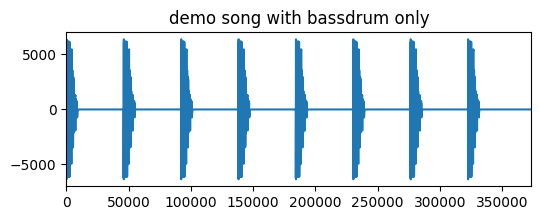

In [21]:
song.keep_sample(14)
player(song, zoom=1., title="demo song with bassdrum only")

Note that the song object is *stateful*! We can't recover the samples we removed. So we need to reload the song:

In [22]:
song = MODSong()
song.load_from_file("./demo.mod")

Loading ./demo.mod... 

FileNotFoundError: [Errno 2] No such file or directory: './demo.mod'

Let's now remove all the drums, and play the song again:

In [ ]:
song.remove_sample(12)
song.remove_sample(13)
song.remove_sample(14)

player(song, zoom=1., title="demo song without drums")

Finally, it would be cool to load our own instruments into the song!

Let's load a "clap" sound, and put it where the bassdrum was before:

In [ ]:
clap = AudioSegment.from_wav("./clap.wav")
player(clap, zoom=1, title="clap waveform")

It sounds a bit harsh, right? That's because we need to play it at a higher note! Let's put it inside the song to see how it sounds, and then we'll change its pitch:

In [ ]:
song.samples[14] = Sample()  # replace the bassdrum with a new sample
song.samples[14].name = "clap"
song.samples[14].waveform = clap.get_array_of_samples()

player(song, zoom=1., title="demo song with claps")

Let's clean it up 🧹 We are going to turn down its volume a bit, and raise its pitch by $12$ semitones:

In [ ]:
song.samples[14].volume = 40  # the maximum volume is 64!
song.tune_sample(sample_idx=14, semitone=12)  # raise the pitch by 12 semitones

player(song, zoom=1., title="demo song with claps")

Of course, we can also play with pitches to modify the main melody.

For example, below we *lower* the pitch of the lead melody by $3$ semitones:

In [ ]:
song.tune_sample(sample_idx=4, semitone=-3)  # lower the pitch by 3 semitones

player(song, zoom=1., title="demo song out of tune")

The effect is that the main melody is now out of tune with the rest of the song 🎶👎

It seems useless here, but being able to finetune the pitch of individual instruments will be important for the main challenge of this hackathon.